63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
========== MODEL PERFORMANCE ==========
Accuracy:      0.8685
Precision:     0.8158
Recall:        0.4570
F1 Score:      0.5858
ROC-AUC:       0.8745

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.82      0.46      0.59       407

    accuracy                           0.87      2000
   macro avg       0.85      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000

Confusion Matrix:
 [[1551   42]
 [ 221  186]]


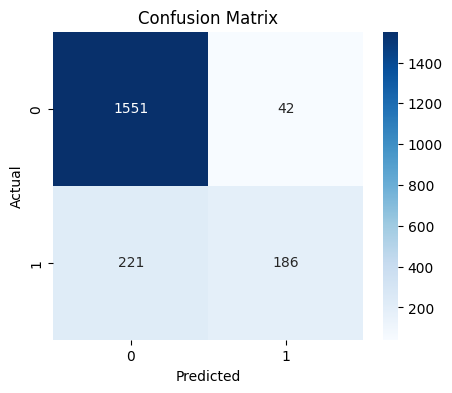

In [9]:
import tensorflow as tf
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

# ====================================================
# 1️⃣ Load Data
# ====================================================
data = pd.read_csv("Churn_Modelling.csv")
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# ====================================================
# 2️⃣ Load the SAME encoders and scaler used during training
# ====================================================
with open('label_encoder_gender.pkl', 'rb') as f:
    label_encoder_gender = pickle.load(f)

with open('onehot_encoder_geo.pkl', 'rb') as f:
    onehot_encoder_geo = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Encode columns using loaded encoders
data['Gender'] = label_encoder_gender.transform(data['Gender'])

geo_encoded = onehot_encoder_geo.transform(data[['Geography']]).toarray()
geo_encoded_df = pd.DataFrame(
    geo_encoded, columns=onehot_encoder_geo.get_feature_names_out(['Geography'])
)

data = pd.concat([data.drop('Geography', axis=1), geo_encoded_df], axis=1)

# ====================================================
# 3️⃣ Split Features and Target
# ====================================================
X = data.drop('Exited', axis=1)
y = data['Exited']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ====================================================
# 4️⃣ Scale using same scaler
# ====================================================
X_test = scaler.transform(X_test)

# ====================================================
# 5️⃣ Load Model
# ====================================================
model = tf.keras.models.load_model('churn_model.h5')

# ====================================================
# 6️⃣ Evaluate
# ====================================================
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("========== MODEL PERFORMANCE ==========")
print(f"Accuracy:      {acc:.4f}")
print(f"Precision:     {prec:.4f}")
print(f"Recall:        {rec:.4f}")
print(f"F1 Score:      {f1:.4f}")
print(f"ROC-AUC:       {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * precision * recall / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for highest F1:", best_threshold)

Best threshold for highest F1: 0.29817718


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = dict(enumerate(class_weights))

model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights
)

Epoch 1/100


C:\Users\Vinit Solanki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5098 - loss: 1874.6172 - val_accuracy: 0.4663 - val_loss: 350.2131
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4955 - loss: 546.0643 - val_accuracy: 0.6250 - val_loss: 41.8077
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4992 - loss: 290.9355 - val_accuracy: 0.7050 - val_loss: 8.2070
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5209 - loss: 142.6461 - val_accuracy: 0.2138 - val_loss: 14.0624
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5105 - loss: 88.3128 - val_accuracy: 0.7487 - val_loss: 4.8610
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5323 - loss: 54.2834 - val_accuracy: 0.7862 - val_loss: 3.5261
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5302 - loss: 36.3647 - val_accuracy: 0.2556 - val_loss: 3.2247
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5478 - loss: 23.4944 - val

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])


Class Weights: {0: np.float64(0.6279434850863422), 1: np.float64(2.4539877300613497)}


C:\Users\Vinit Solanki\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6123 - loss: 0.6461 - val_accuracy: 0.7344 - val_loss: 0.5593 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6852 - loss: 0.6032 - val_accuracy: 0.7175 - val_loss: 0.5561 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7006 - loss: 0.5787 - val_accuracy: 0.7231 - val_loss: 0.5330 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7048 - loss: 0.5688 - val_accuracy: 0.7306 - val_loss: 0.5198 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7237 - loss: 0.5562 - val_accuracy: 0.7350 - val_loss: 0.5129 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7212 - loss: 0.5442 - val_accuracy: 0.7425 - val_loss: 0.5038 - learning_rate: 0.0010
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7408 - loss: 0

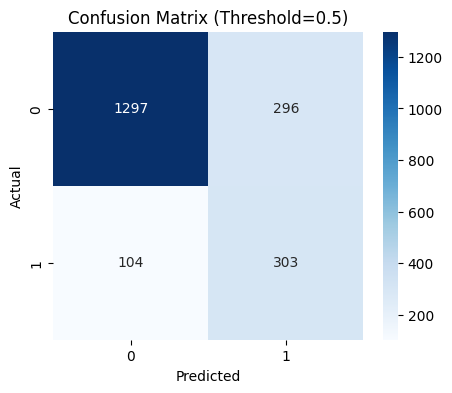


Best Threshold (max F1): 0.624

========== OPTIMIZED PERFORMANCE ==========
Accuracy:  0.8555
Precision: 0.6553
Recall:    0.6118
F1 Score:  0.6328
ROC-AUC:   0.8630


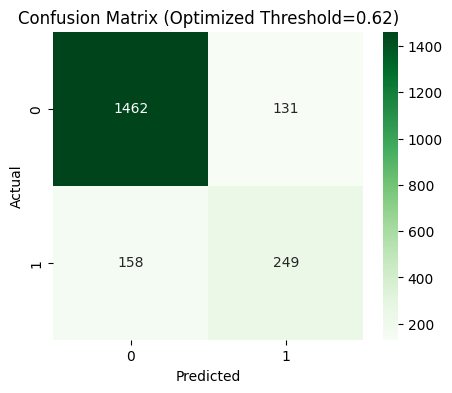

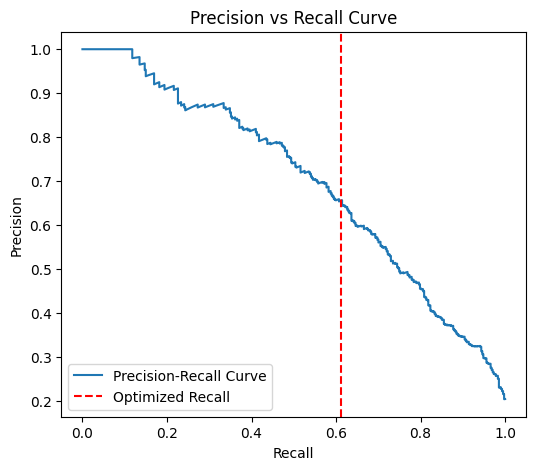

In [13]:
# ============================================================
# CUSTOMER CHURN PREDICTION (Optimized ANN)
# ============================================================
# -------------------------------
# 1️⃣ IMPORTS
# -------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.utils import class_weight
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, classification_report,
    precision_recall_curve
)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# ============================================================
# 2️⃣ DATA PREPARATION
# ============================================================
data = pd.read_csv("Churn_Modelling.csv")

# Drop irrelevant columns
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# Encode Gender
label_encoder_gender = LabelEncoder()
data['Gender'] = label_encoder_gender.fit_transform(data['Gender'])  # Male=0, Female=1

# One-hot encode Geography
onehot_encoder_geo = OneHotEncoder(sparse_output=False)
geo_encoded = onehot_encoder_geo.fit_transform(data[['Geography']])
geo_encoded_df = pd.DataFrame(
    geo_encoded, columns=onehot_encoder_geo.get_feature_names_out(['Geography'])
)

# Merge back
data = pd.concat([data.drop('Geography', axis=1), geo_encoded_df], axis=1)

# Define features and target
X = data.drop('Exited', axis=1)
y = data['Exited']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ============================================================
# 3️⃣ BUILD & TRAIN MODEL
# ============================================================

# Compute class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Build ANN architecture
model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks for optimization
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ============================================================
# 4️⃣ EVALUATION
# ============================================================

# Predict probabilities
y_pred_prob = model.predict(X_test)
y_pred_default = (y_pred_prob > 0.5).astype(int)

# Metrics at default threshold (0.5)
acc = accuracy_score(y_test, y_pred_default)
prec = precision_score(y_test, y_pred_default)
rec = recall_score(y_test, y_pred_default)
f1 = f1_score(y_test, y_pred_default)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("\n========== MODEL PERFORMANCE (Threshold = 0.5) ==========")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_default))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_default)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Threshold=0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ============================================================
# 5️⃣ THRESHOLD OPTIMIZATION (Maximize F1)
# ============================================================
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nBest Threshold (max F1): {best_threshold:.3f}")

# Recompute metrics with optimal threshold
y_pred_opt = (y_pred_prob > best_threshold).astype(int)
acc_opt = accuracy_score(y_test, y_pred_opt)
prec_opt = precision_score(y_test, y_pred_opt)
rec_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)
roc_auc_opt = roc_auc_score(y_test, y_pred_prob)

print("\n========== OPTIMIZED PERFORMANCE ==========")
print(f"Accuracy:  {acc_opt:.4f}")
print(f"Precision: {prec_opt:.4f}")
print(f"Recall:    {rec_opt:.4f}")
print(f"F1 Score:  {f1_opt:.4f}")
print(f"ROC-AUC:   {roc_auc_opt:.4f}")

# Confusion Matrix after optimization
cm_opt = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens')
plt.title(f"Confusion Matrix (Optimized Threshold={best_threshold:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.axvline(x=rec_opt, color='r', linestyle='--', label='Optimized Recall')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall Curve")
plt.legend()
plt.show()

# ============================================================
# 6️⃣ SAVE MODEL AND ENCODERS
# ============================================================
model.save('churn_model_v2.h5')

with open('label_encoder_gender.pkl', 'wb') as f:
    pickle.dump(label_encoder_gender, f)
with open('onehot_encoder_geo.pkl', 'wb') as f:
    pickle.dump(onehot_encoder_geo, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
